Question 5 [10 marks]

Calculate the stimulus triggered by pairs of spikes: For intervals of 2 ms, 5 ms, 10 ms, 20 ms and 50 ms calculate the average stimulus before the first spike in a pair of spikes separated by that interval; Do this for both the case where the spikes are not necessarily adjacent and the case where they are. Speculate on the role of the refractory period in any differences in the STA between the two scenarios (adjacent vs. non-adjacent spikes).

Number of spikes: 53601
Spike times: [3.400000e-02 4.400000e-02 5.000000e-02 ... 1.199872e+03 1.199882e+03
 1.199894e+03]
Interval 2 ms - Adjacent pairs: 1650
Interval 2 ms - All pairs: 1650
Interval 4 ms - Adjacent pairs: 9641
Interval 4 ms - All pairs: 9676
Interval 10 ms - Adjacent pairs: 4895
Interval 10 ms - All pairs: 11930
Interval 20 ms - Adjacent pairs: 514
Interval 20 ms - All pairs: 9569
Interval 50 ms - Adjacent pairs: 165
Interval 50 ms - All pairs: 6892


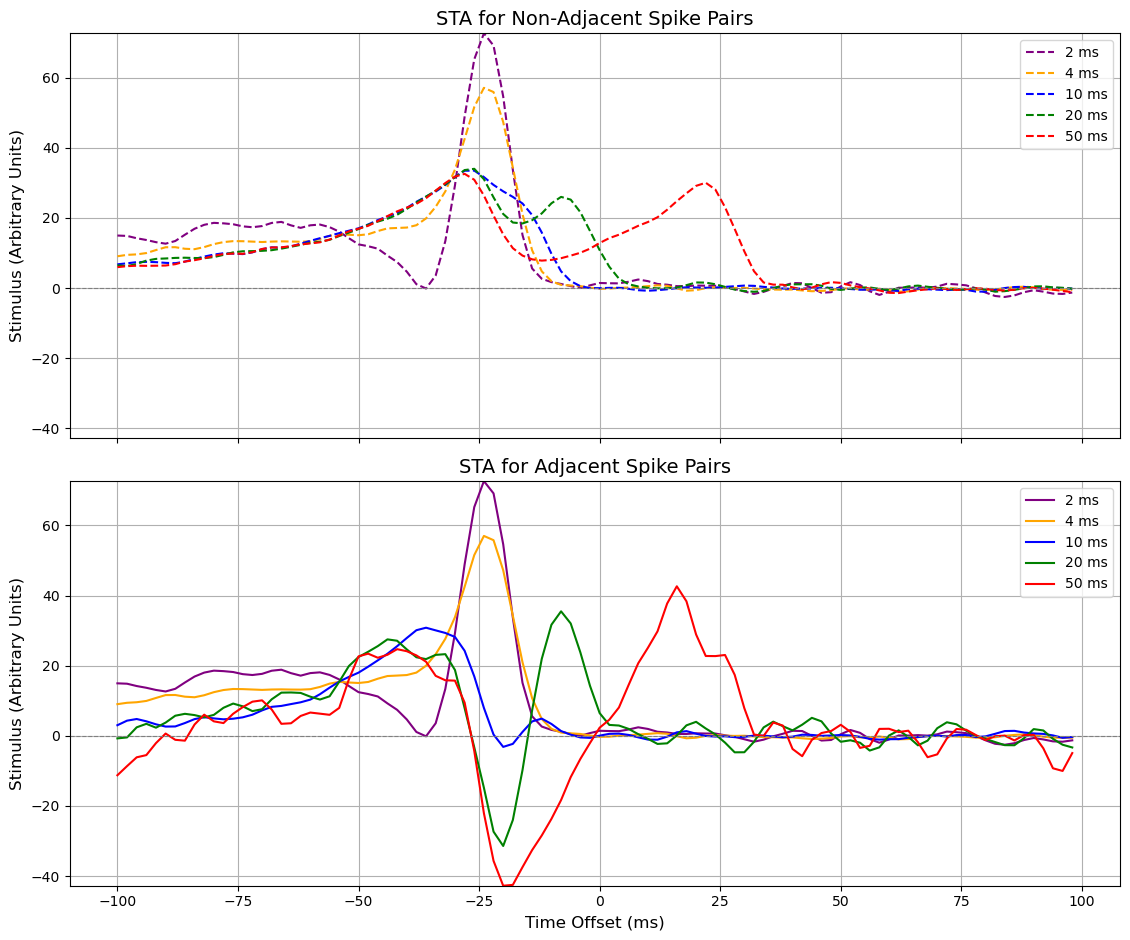

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
rho_file_path = 'rho.dat'
stim_file_path = 'stim.dat'
rho = np.loadtxt(rho_file_path)
stim = np.loadtxt(stim_file_path)

# Constants
dt = 2e-3  # Sampling interval (2 ms)
time_window = 0.1  # 100 ms window
window_steps = int(time_window / dt)  # Number of steps in the window
time_offsets = np.arange(-window_steps, window_steps) * dt  # Time offsets
intervals = [2e-3, 4e-3, 10e-3, 20e-3, 50e-3]  # Spike pair intervals
colors = {
    2e-3: 'purple',
    4e-3: 'orange',
    10e-3: 'blue',
    20e-3: 'green',
    50e-3: 'red',
}

# Extract spike times
spike_times = np.where(rho == 1)[0] * dt  # Convert indices to time in seconds
print(f"Number of spikes: {len(spike_times)}")
print("Spike times:", spike_times)

# Optimized STA calculation function
def calculate_sta_for_spike_pairs(spike_times, stim, interval, sampling_interval, adjacent_only=False):
    interval_steps = int(interval / sampling_interval)  # Convert interval to steps
    sta = np.zeros(2 * window_steps)  # Initialize STA array
    count = 0

    spike_indices = (spike_times / sampling_interval).astype(int)

    if adjacent_only:
        # For adjacent spike pairs only
        for i in range(len(spike_indices) - 1):
            if spike_indices[i + 1] - spike_indices[i] == interval_steps:
                if spike_indices[i] >= window_steps and spike_indices[i] + window_steps < len(stim):
                    sta += stim[spike_indices[i] - window_steps:spike_indices[i] + window_steps]
                    count += 1
        print(f"Interval {interval * 1000:.0f} ms - Adjacent pairs: {count}")
    else:
        # For all possible spike pairs
        for i in range(len(spike_indices)):
            valid_indices = np.where(
                (spike_indices > spike_indices[i]) &
                (spike_indices - spike_indices[i] == interval_steps)
            )[0]
            for j in valid_indices:
                if spike_indices[i] >= window_steps and spike_indices[i] + window_steps < len(stim):
                    sta += stim[spike_indices[i] - window_steps:spike_indices[i] + window_steps]
                    count += 1
        print(f"Interval {interval * 1000:.0f} ms - All pairs: {count}")

    return sta / count if count > 0 else np.zeros_like(sta)

# Calculate STAs for adjacent and non-adjacent spike pairs
stas_adjacent = {}
stas_non_adjacent = {}

for interval in intervals:
    stas_adjacent[interval] = calculate_sta_for_spike_pairs(spike_times, stim, interval, dt, adjacent_only=True)
    stas_non_adjacent[interval] = calculate_sta_for_spike_pairs(spike_times, stim, interval, dt, adjacent_only=False)

# Define y-axis limits for consistent plotting
y_min = min(
    min(stas_adjacent[interval].min(), stas_non_adjacent[interval].min()) for interval in intervals
)
y_max = max(
    max(stas_adjacent[interval].max(), stas_non_adjacent[interval].max()) for interval in intervals
)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

# Plot Non-Adjacent STAs (at the top)
axes[0].set_title("STA for Non-Adjacent Spike Pairs", fontsize=14)
for interval in intervals:
    axes[0].plot(
        time_offsets * 1000,  # Convert to milliseconds
        stas_non_adjacent[interval],  # STA values
        label=f"{interval * 1000:.0f} ms",
        color=colors[interval],
        linestyle='--',
    )
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[0].legend(fontsize=10)
axes[0].grid(True)

# Plot Adjacent STAs (below)
axes[1].set_title("STA for Adjacent Spike Pairs", fontsize=14)
for interval in intervals:
    axes[1].plot(
        time_offsets * 1000,  # Convert to milliseconds
        stas_adjacent[interval],  # STA values
        label=f"{interval * 1000:.0f} ms",
        color=colors[interval],
        linestyle='-',
    )
axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[1].legend(fontsize=10)
axes[1].grid(True)

# Set common labels and limits
for ax in axes:
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel("Stimulus (Arbitrary Units)", fontsize=12)

axes[1].set_xlabel("Time Offset (ms)", fontsize=12)

# Adjust layout and show plot
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()


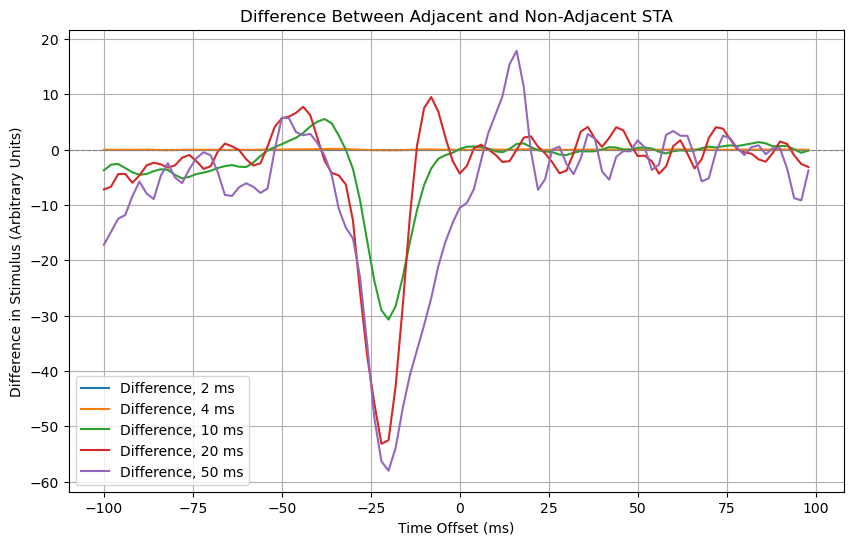

In [7]:
# Plot the difference between adjacent and non-adjacent STA
plt.figure(figsize=(10, 6))
for interval in intervals:
    difference = stas_adjacent[interval] - stas_non_adjacent[interval]
    plt.plot(time_offsets * 1000, difference, label=f"Difference, {interval * 1000:.0f} ms")

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel("Time Offset (ms)")
plt.ylabel("Difference in Stimulus (Arbitrary Units)")
plt.title("Difference Between Adjacent and Non-Adjacent STA")
plt.legend()
plt.grid(True)
plt.show()

There is no difference between the 2ms and 4ms intervals for adjacent and non-adjacent pairs. This is most likely because at these shorter intervals, only adjacent spike pairs exist. 

This graph highlights how adjacent spike pairs are more tightly linked to specific, strong stimulus features, while non-adjacent pairs represent a broader stimulus encoding over larger time scales. The differences seen near the spike events provide insights into how neurons encode temporal stimulus patterns and how the refractory period impacts the spike-triggered average.

The refractory period limits closely spaced spikes, reducing variability in adjacent spike pairs and emphasizing consistent stimulus features. Non-adjacent pairs, unaffected by the refractory period, reflect broader stimulus dynamics, leading to greater variability in the STA.

For a pair of spikes, the Spike Triggered Average (STA) is typically calculated for the stimulus pattern leading up to the first spike in the pair.

Why dip below zero for adjacent pairs?- refactory period

What does the STA represent?

The STA is the average stimulus pattern in the time window before a spike (or pair of spikes).
For adjacent spikes, the STA shows the stimulus leading up to the first spike in a pair where the second spike occurs soon after (e.g., within a 2 ms or 10 ms interval).
Why does the refractory period matter?

A neuron enters a refractory period after firing a spike, during which it is less likely to fire again unless the stimulus is very strong.
If two spikes occur close together (i.e., adjacent spikes), it means the stimulus must have been strong enough to "overcome" the suppression caused by the refractory period of the first spike.
How does this create a dip in the STA for adjacent spikes?

The STA reflects the average stimulus leading to adjacent spikes. To generate two closely timed spikes, the stimulus may first peak (strong enough to trigger the first spike) and then dip (weaker or inhibitory during the refractory period) before the second spike occurs.
The "dip" in the STA occurs because the suppression caused by the refractory period affects the stimulus patterns needed to generate adjacent spikes. The stimulus just before the first spike may show a trough as part of this dynamic.
Why doesn’t this happen for non-adjacent spikes?

Non-adjacent spikes are spaced far enough apart that the second spike is not influenced by the refractory period of the first spike.
As a result, the STA for non-adjacent spikes reflects a broader, more general stimulus pattern and does not exhibit the "dip" seen for adjacent spikes.


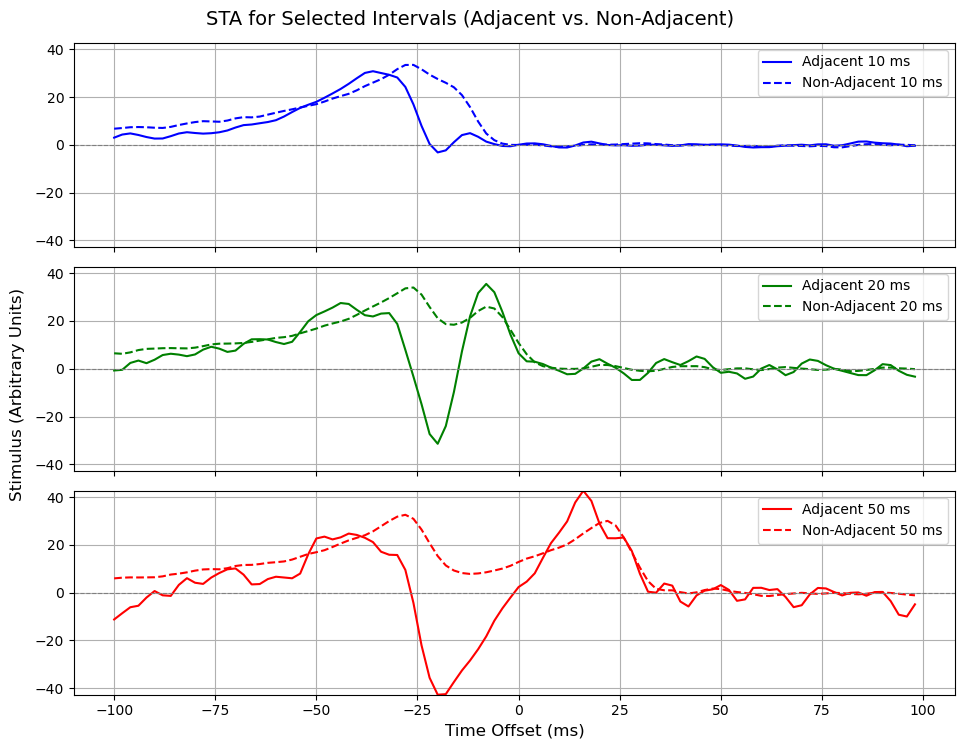

In [9]:
import matplotlib.pyplot as plt

# Sampling interval (e.g., 2 ms or as per your data)
sampling_interval = 2e-3  # 2 ms sampling interval

selected_intervals = [10e-3, 20e-3, 50e-3]  # Intervals in seconds

# Generate the correct time_offsets based on window size
time_window_steps = len(stas_adjacent[selected_intervals[0]])  # Use the first STA to determine the window size
time_offsets = np.arange(-time_window_steps // 2, time_window_steps // 2) * sampling_interval  # Correctly size time offsets

# Define consistent colors for each interval
colors = {
    10e-3: 'blue',
    20e-3: 'green',
    50e-3: 'red',
}

# Find the global y-axis limits
y_min = min(
    min(stas_adjacent[interval].min(), stas_non_adjacent[interval].min())
    for interval in selected_intervals
)
y_max = max(
    max(stas_adjacent[interval].max(), stas_non_adjacent[interval].max())
    for interval in selected_intervals
)

# Create subplots
fig, axes = plt.subplots(len(selected_intervals), 1, figsize=(10, 8), sharex=True)

for idx, interval in enumerate(selected_intervals):
    ax = axes[idx]
    # Plot adjacent STA
    ax.plot(
        time_offsets * 1000,  # Convert time offsets to milliseconds
        stas_adjacent[interval],  # Adjacent STA
        label=f"Adjacent {interval * 1000:.0f} ms",
        linestyle='-',  # Solid line for adjacent
        color=colors[interval],  # Use consistent color
    )
    # Plot non-adjacent STA
    ax.plot(
        time_offsets * 1000,  # Convert time offsets to milliseconds
        stas_non_adjacent[interval],  # Non-adjacent STA
        label=f"Non-Adjacent {interval * 1000:.0f} ms",
        linestyle='--',  # Dashed line for non-adjacent
        color=colors[interval],  # Use consistent color
    )
    # Set shared y-axis limits
    ax.set_ylim(y_min, y_max)
    # Add grid, legend, and horizontal reference line
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.legend()
    ax.grid(True)

# Add a single y-axis label and shared x-axis label
fig.text(0.04, 0.5, "Stimulus (Arbitrary Units)", va='center', rotation='vertical', fontsize=12)
axes[-1].set_xlabel("Time Offset (ms)", fontsize=12)
fig.suptitle("STA for Selected Intervals (Adjacent vs. Non-Adjacent)", fontsize=14)

# Adjust layout to remove space under the title
plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust rect: top margin reduced slightly
plt.show()
